In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import seaborn as sns

In [14]:
df = pd.read_csv('E:/STA 221/STA_221_project_code/fog_aware_stats_horizontal_6_patches_pivot.csv')

df['Label_train'] = 1*(df['Label']=='foggy')

In [15]:
df[['Label_train', 'Label']].value_counts()

Label_train  Label    
0            not_foggy    6374
1            foggy        1622
dtype: int64

In [17]:
label_counts = df['Label'].value_counts()

# Number of data points to drop from the "foggy" class
num_to_drop = 4752

# Check if the number to drop is greater than the count of "foggy" class
if num_to_drop > label_counts[0]:
    print("Warning: The specified number of data points to drop is greater than the count of 'foggy' class.")
else:
    # Randomly drop data points from the "foggy" class
    df_to_drop = df[df['Label_train'] == 0].sample(n=num_to_drop, random_state=42)
    df_filtered = df.drop(df_to_drop.index)

    # Display the resulting DataFrame
    print(df_filtered)
    print(label_counts)

                                  photo      Label           site  hour  \
2      2022_07-04.0700_agatebeachor.jpg  not_foggy   agatebeachor     7   
3      2022_07-04.0730_agatebeachor.jpg  not_foggy   agatebeachor     7   
4       2022_07-04.0730_otterrockor.jpg  not_foggy    otterrockor     7   
5      2022_07-04.0800_agatebeachor.jpg  not_foggy   agatebeachor     8   
9       2022_07-04.0830_otterrockor.jpg  not_foggy    otterrockor     8   
...                                 ...        ...            ...   ...   
7982    2023_09-30.1330_cannonbeach.jpg  not_foggy    cannonbeach    13   
7986   2023_09-30.1600_agatebeachor.jpg  not_foggy   agatebeachor    16   
7988    2023_09-30.1630_cannonbeach.jpg  not_foggy    cannonbeach    16   
7989  2023_09-30.1630_lincolncityor.jpg  not_foggy  lincolncityor    16   
7994    2023_09-30.2030_otterrockor.jpg  not_foggy    otterrockor    20   

      mscn_var_0  mscn_var_1  mscn_var_2  mscn_var_3  mscn_var_4  mscn_var_5  \
2       0.086452   

In [19]:
label_counts = df_filtered['Label'].value_counts()
print(label_counts)

not_foggy    1622
foggy        1622
Name: Label, dtype: int64


In [20]:
X = np.array(df_filtered.drop(['Label', 'Label_train', 'photo', 'site'], axis=1))
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

y = np.array(df_filtered['Label_train'])



X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [21]:
# Create a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', random_state=42)

# Perform cross-validation predictions
y_pred_cv = cross_val_predict(model, X_scaled, y, cv=5)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

Accuracy: 0.9045174537987679
Precision: 0.9104166666666667
Recall: 0.8973305954825462
F1 Score: 0.90382626680455
AUC-ROC Score: 0.9699644557256639


In [22]:
def plot_confusion_matrix(y_test, y_test_pred, model_name):
  test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
  group_names = ['True Negative (TN)', 'False Positive (FP)',
                'False Negative (FN)', 'True Positive (TP)']
  group_counts = ["{0:0.0f}".format(value) for value in test_confusion_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in test_confusion_matrix.flatten()/np.sum(test_confusion_matrix)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  # Creating the heatmap
  plt.figure(figsize=(10,7))
  sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Blues')
  plt.title("Confusion Matrix for "+ model_name+ " (using Test Set)")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.show()

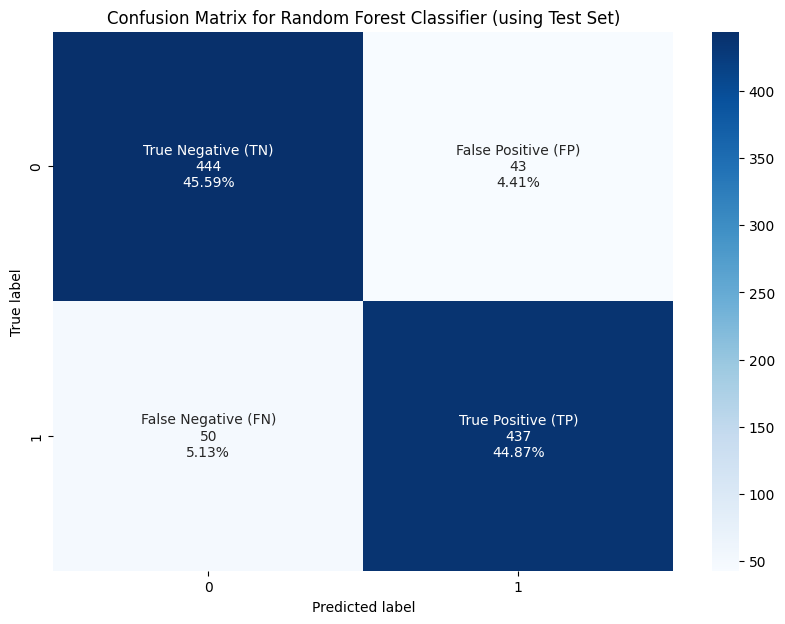

In [23]:
plot_confusion_matrix(y_test,y_pred_test,"Random Forest Classifier")

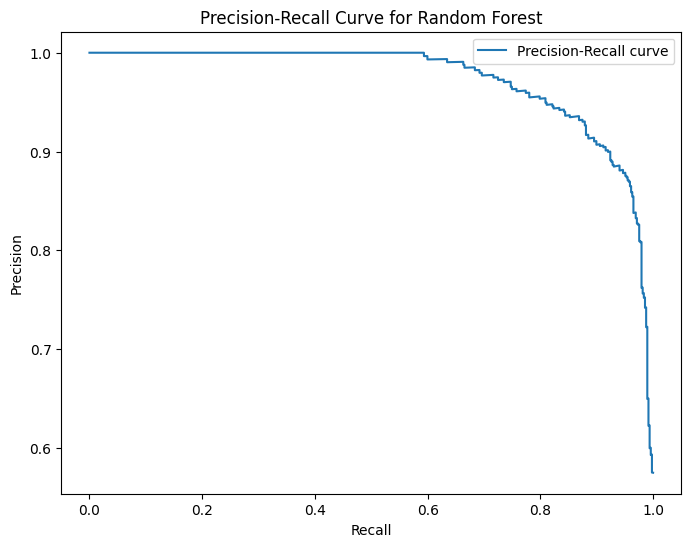

In [24]:
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.show()

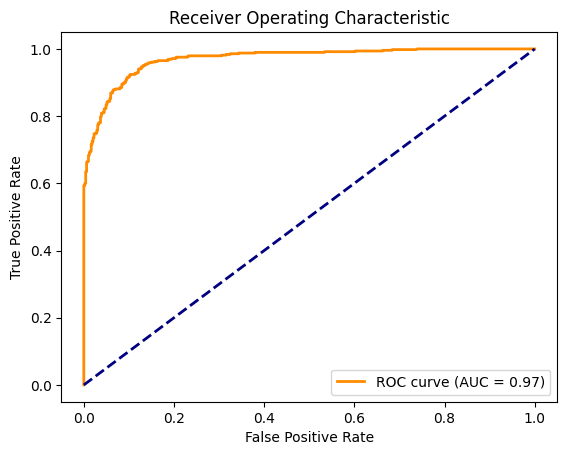

In [25]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

                    Feature    Importance
27           rms_contrast_2  5.133470e-03
26           rms_contrast_1  4.722793e-03
45              color_sat_2  3.696099e-03
46              color_sat_3  2.977413e-03
28           rms_contrast_3  2.772074e-03
44              color_sat_1  2.669405e-03
34                entropy_3  1.950719e-03
24  coef_or_var_sharpness_5  1.950719e-03
8            vertical_var_1  1.848049e-03
5                mscn_var_4  1.848049e-03
50                     CF_1  1.540041e-03
15              sharpness_2  1.334702e-03
4                mscn_var_3  1.334702e-03
3                mscn_var_2  1.232033e-03
48              color_sat_5  1.232033e-03
52                     CF_3  1.129363e-03
33                entropy_2  1.026694e-03
36                entropy_5  1.026694e-03
31                entropy_0  9.240246e-04
49                     CF_0  9.240246e-04
35                entropy_4  8.213552e-04
54                     CF_5  8.213552e-04
20  coef_or_var_sharpness_1  8.213

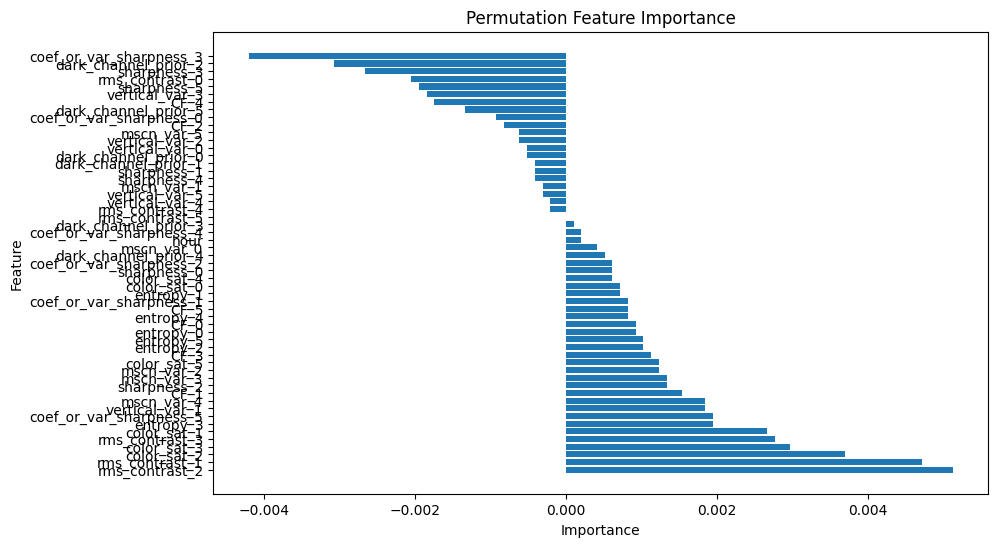

In [26]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature importance scores
feature_importance = result.importances_mean

# Making a X_copy dataframe with all the feature columns
X_copy = df_filtered.drop(['Label', 'Label_train', 'photo', 'site'], axis=1)

# Get the feature names
feature_names = X_copy.columns

# Create a DataFrame to combine feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importance
print(feature_importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.show()

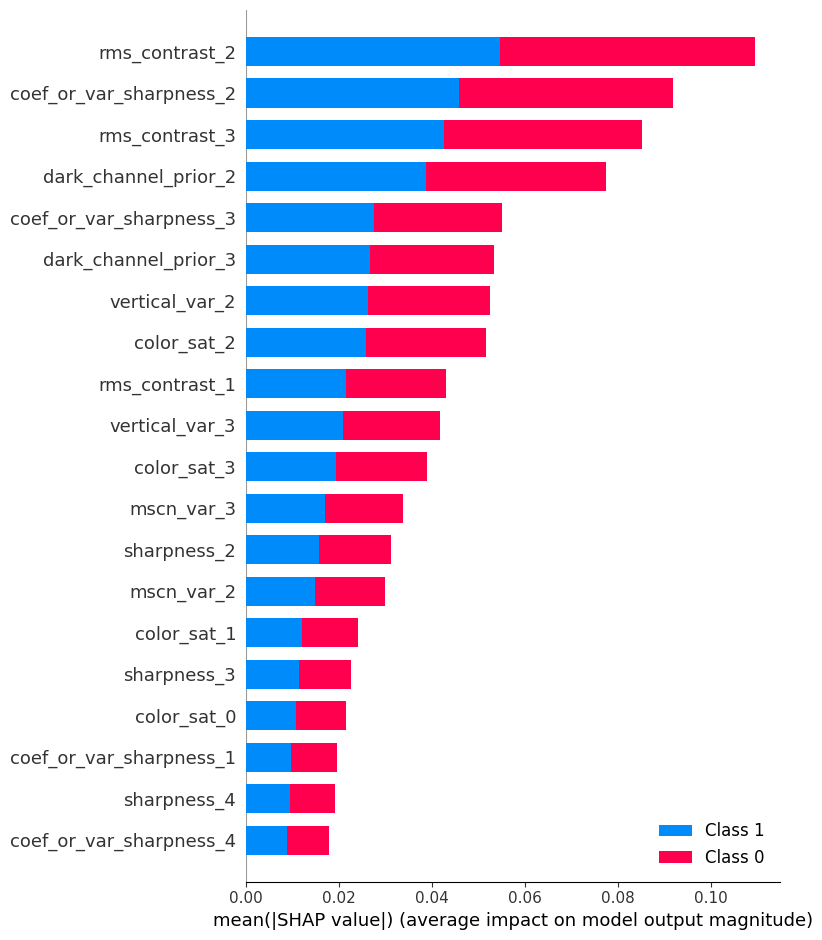

In [27]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_copy)